# Near-reference variability

Analysis of near-reference variability across datasets for Supplementary Figure 1.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr, wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/external")
utils.download_dataset("data/processed/behavior")

cde_data  = pd.read_csv("../data/processed/behavior/behavior.csv")
zamboni   = pd.read_csv("../data/external/zamboni2016.csv")
fritsche  = pd.read_csv("../data/external/fritsche2019.csv")
rademaker = pd.read_csv("../data/external/rademaker2019.csv")

downloading data/external...
data/external already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


---
## Reference attraction: Rademaker et al. (2019)

Rademaker et al. (2019) is when the intervening reference serves as a distractor.

+ (`n_bin`-1) violins will be generated

In [3]:
# Parameters
cutoff_range = 25 # range defining "reference" [degree]
cutoff_near  = 8  # range defining "Near" references [degree]
n_bin        = 8
delta        = (rademaker.orient_target - rademaker.orient_distr - 90.) % 180 - 90 

#
edges     = np.concatenate([[-np.inf],np.linspace(-cutoff_range,cutoff_range,num=n_bin)])
digitized = np.digitize(delta, edges, right=True)
digit_of_interest = np.arange(2,n_bin+1)
neg_ref_relative  = np.round(edges[1:(-1)] + (edges[2]-edges[1])/2.)

In [4]:
# quantiles
quantiles = np.nan*np.empty([len(neg_ref_relative),3])
for i_bin, v_bin in enumerate(digit_of_interest):
    quantiles[i_bin,0] = np.quantile(rademaker.error[digitized==v_bin],0.25)
    quantiles[i_bin,1] = np.quantile(rademaker.error[digitized==v_bin],0.50)
    quantiles[i_bin,2] = np.quantile(rademaker.error[digitized==v_bin],0.75)

+ Population data

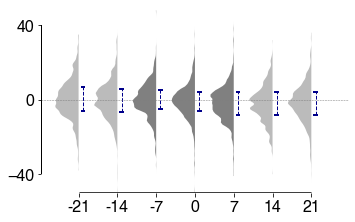

In [5]:
plt.figure()
ax = plt.gca()
utils.set_size([4,2.5])

violin_plot = ax.violinplot([
    rademaker.error[digitized==v_bin] for v_bin in digit_of_interest],
    widths=1.2, showextrema=False, bw_method=.12)

for i_pc, v_pc in enumerate(violin_plot['bodies']):
    if i_pc in np.where(np.abs(neg_ref_relative)<cutoff_near)[0]: 
        v_pc.set_facecolor("#616161")    
    else: 
        v_pc.set_facecolor("#AAAAAA")
    mmm = np.mean(v_pc.get_paths()[0].vertices[:, 0])    
    v_pc.get_paths()[0].vertices[:, 0] = np.clip(v_pc.get_paths()[0].vertices[:, 0], -np.inf, mmm)
    v_pc.set_alpha(0.8)
    
ax.set_ylim([-50,50])
ax.vlines(np.arange(1,len(neg_ref_relative)+1)+0.11, quantiles[:,0], quantiles[:,2], color='darkblue', linestyle='dashed', linewidth=1)
ax.hlines(quantiles[:,2], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.hlines(quantiles[:,0], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)

ax.set_xticks(np.arange(1,len(neg_ref_relative)+1))
ax.set_xticklabels(np.round(neg_ref_relative).astype(int))
utils.draw_publish_axis(ax, xrange=(1,7), yrange=(-40,40), xticks=None, yticks=[-40,0,40])
if utils.LABEL:
    ax.set_xlabel(r'Stimulus - Reference $(^\circ)$')
    ax.set_ylabel(r'Estimation error $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1d.pdf',bbox_inches='tight')
plt.show()

+ Individual data

In [6]:
id_unique = np.unique(rademaker.subject)
iqr_list  = np.nan*np.zeros([len(id_unique),len(neg_ref_relative)])

for i_id, v_id in enumerate(id_unique):
    for i_bin, v_bin in enumerate(digit_of_interest):
        idx = (rademaker.subject==v_id) & (digitized==v_bin)
        iqr_list[i_id,i_bin] = iqr(rademaker.error[idx])

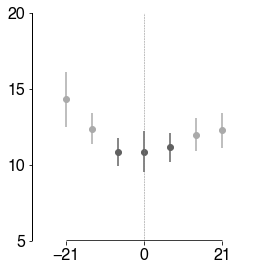

In [7]:
cutoff_in = np.abs(neg_ref_relative)<cutoff_near
m_iqr = np.mean(iqr_list,axis=0)
s_iqr = np.std(iqr_list,axis=0)/np.sqrt(len(id_unique))

plt.figure()
ax = plt.gca()
utils.set_size([3,3])
plt.vlines(neg_ref_relative[cutoff_in], 
           (m_iqr-s_iqr)[cutoff_in], (m_iqr+s_iqr)[cutoff_in], color='#616161')
plt.scatter(neg_ref_relative[cutoff_in], m_iqr[cutoff_in],  color='#616161')
plt.vlines(neg_ref_relative[~cutoff_in], 
           (m_iqr-s_iqr)[~cutoff_in], (m_iqr+s_iqr)[~cutoff_in], color='#AAAAAA')
plt.scatter(neg_ref_relative[~cutoff_in], m_iqr[~cutoff_in], color='#AAAAAA')
plt.xlim([-30,30])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([5,20])

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(5,20), xticks=[-21,0,21], yticks=[5,10,15,20])
if utils.LABEL:
    plt.xlabel(r'Stimulus - Reference $(^\circ)$')
    plt.ylabel(r'Interquartile range $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1e.pdf',bbox_inches='tight')
plt.show()

+ IQR ratio

In [8]:
iqrr_list = np.nan*np.zeros([len(id_unique),2])
idx_n     = np.isin(digitized,[4,5,6])
idx_f     = np.isin(digitized,[2,3,7,8])

for i_id, v_id in enumerate(id_unique):
    idx = (rademaker.subject==v_id)
    iqrr_list[i_id,0] = iqr(rademaker.error[idx&idx_n])
    iqrr_list[i_id,1] = iqr(rademaker.error[idx&idx_f])

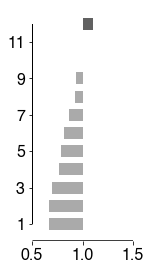

In [9]:
plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])

patches = plt.barh(np.arange(len(id_unique)), 
                   np.sort(iqrr_list[:,0]/iqrr_list[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqrr_list[:,0]/iqrr_list[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')

ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels([1,3,5,7,9,11])
if utils.LABEL:
    plt.xlabel(r'IQR ratio' '\n' '(Near / Far)')
    plt.ylabel(r'Participants')
utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,11), xticks=None, yticks=None)
plt.savefig(f'{utils.DIR_FIGURE}/sfig1f.pdf',bbox_inches='tight')
plt.show()

In [10]:
%%capture
ttest  = DescrStatsW(iqrr_list[:,0]/iqrr_list[:,1]-1)
wilcox = wilcoxon(iqrr_list[:,0]/iqrr_list[:,1]-1)

In [11]:
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqrr_list)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(11)= -3.6019931302211403 p= 0.004155397556642711
95% CI= [0.76155753 0.94243304]

Wilcoxon signed-rank test (without continuity correction)
V= 3.0 p= 0.012458141993823996


----

## Reference repulsion: 1. Zamboni et al. (2016)

Only "reference absent" case.

In [12]:
n_bin   = 10
delta   = zamboni.Delta
error   = (zamboni.Estimate - zamboni.Delta - 90. ) % 180 - 90.

edges     = np.concatenate([[-np.inf],np.linspace(-cutoff_range,cutoff_range,num=n_bin)])
digitized = np.digitize(delta, edges, right=True)
digit_of_interest = np.arange(3,n_bin)
neg_ref_relative  = np.round(edges[2:(-2)] + (edges[2]-edges[1])/2.)

# quantiles
quantiles = np.nan*np.empty([len(neg_ref_relative),3])
for i_bin, v_bin in enumerate(digit_of_interest):
    quantiles[i_bin,0] = np.quantile(error[digitized==v_bin],0.25)
    quantiles[i_bin,1] = np.quantile(error[digitized==v_bin],0.50)
    quantiles[i_bin,2] = np.quantile(error[digitized==v_bin],0.75)

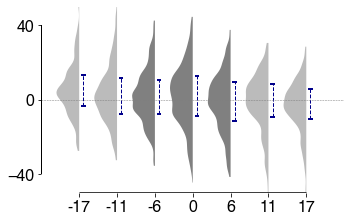

In [13]:
plt.figure()
ax = plt.gca()
utils.set_size([4,2.5])

violin_plot = ax.violinplot([
    error[digitized==v_bin] for v_bin in digit_of_interest],
    widths=1.2, showextrema=False, bw_method=.2)

for i_pc, v_pc in enumerate(violin_plot['bodies']):
    if i_pc in np.where(np.abs(neg_ref_relative)<cutoff_near)[0]: 
        v_pc.set_facecolor("#616161")    
    else: 
        v_pc.set_facecolor("#AAAAAA")
    mmm = np.mean(v_pc.get_paths()[0].vertices[:, 0])    
    v_pc.get_paths()[0].vertices[:, 0] = np.clip(v_pc.get_paths()[0].vertices[:, 0], -np.inf, mmm)
    v_pc.set_alpha(0.8)

ax.set_ylim([-50,50])
ax.set_xlim(0,len(neg_ref_relative)+1)
ax.vlines(np.arange(1,len(neg_ref_relative)+1)+0.11, quantiles[:,0], quantiles[:,2], color='darkblue', linestyle='dashed', linewidth=1)
ax.hlines(quantiles[:,2], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.hlines(quantiles[:,0], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)

utils.draw_publish_axis(ax, xrange=(1,7), yrange=(-40,40), xticks=None, yticks=[-40,0,40])
ax.set_xticks(np.arange(1,len(neg_ref_relative)+1))
ax.set_xticklabels(neg_ref_relative.astype(int))
if utils.LABEL:
    ax.set_xlabel(r'Stimulus - Reference $(^\circ)$')
    ax.set_ylabel(r'Estimation error $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1a_zamboni.pdf',bbox_inches='tight')
plt.show()

In [14]:
id_unique = np.unique(zamboni.ID)
iqr_list  = np.nan*np.zeros([len(id_unique),len(neg_ref_relative)])

for i_id, v_id in enumerate(id_unique):
    for i_bin, v_bin in enumerate(digit_of_interest):
        idx = (zamboni.ID==v_id) & (digitized==v_bin)
        iqr_list[i_id,i_bin] = iqr(error[idx])

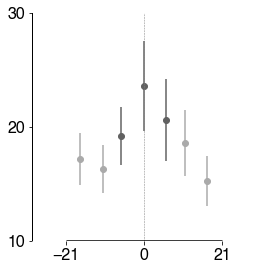

In [15]:
cutoff_in = np.abs(neg_ref_relative)<cutoff_near

m_iqr = np.mean(iqr_list,axis=0)
s_iqr = np.std(iqr_list,axis=0)/np.sqrt(len(id_unique))

plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.vlines(neg_ref_relative[cutoff_in], 
           (m_iqr-s_iqr)[cutoff_in], (m_iqr+s_iqr)[cutoff_in], color='#616161')
plt.scatter(neg_ref_relative[cutoff_in], m_iqr[cutoff_in], color='#616161')

plt.vlines(neg_ref_relative[~cutoff_in], 
           (m_iqr-s_iqr)[~cutoff_in], (m_iqr+s_iqr)[~cutoff_in], color='#AAAAAA')
plt.scatter(neg_ref_relative[~cutoff_in], m_iqr[~cutoff_in], color='#AAAAAA')
plt.xlim([-30,30])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([10,30])

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(10,30), xticks=[-21,0,21], yticks=[10,20,30])
if utils.LABEL:
    plt.xlabel(r'Stimulus - Reference $(^\circ)$')
    plt.ylabel(r'Interquartile range $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1b_zamboni.pdf',bbox_inches='tight')
plt.show()

In [16]:
iqrr_list = np.nan*np.zeros([len(id_unique),2])
idx_n     = np.isin(digitized,[5,6,7])
idx_f     = np.isin(digitized,[3,4,8,9])

for i_id, v_id in enumerate(id_unique):
    idx = (zamboni.ID==v_id)
    iqrr_list[i_id,0] = iqr(error[idx&idx_n])
    iqrr_list[i_id,1] = iqr(error[idx&idx_f])

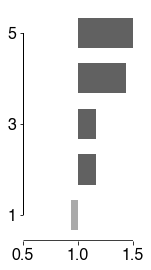

In [17]:
plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])

patches = plt.barh(np.arange(len(id_unique)), np.sort(iqrr_list[:,0]/iqrr_list[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqrr_list[:,0]/iqrr_list[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,2,4])
ax.set_yticklabels([1,3,5])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,4), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel(r'IQR ratio' '\n' '(Near / Far)')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1c_zamboni.pdf',bbox_inches='tight')
plt.show()

In [18]:
ttest  = DescrStatsW(iqrr_list[:,0]/iqrr_list[:,1]-1)
wilcox = wilcoxon(iqrr_list[:,0]/iqrr_list[:,1]-1)
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqrr_list)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(4)= 2.327063223497296 p= 0.08051074420175852
95% CI= [0.95381931 1.52446155]

Wilcoxon signed-rank test (without continuity correction)
V= 1.0 p= 0.125


## Reference repulsion: 2. Fritsche et al. (2019)

In [19]:
cutoff_range = 15
n_bin     = 8
delta     = (fritsche.Stim - fritsche.Bdry - 90.) % 180 - 90 
error     = (fritsche.Estim - fritsche.Stim - 90.) % 180 - 90 
concat    = np.concatenate
edges     = concat([[-np.inf],np.linspace(-cutoff_range,cutoff_range,num=n_bin)])
digitized = np.digitize(delta, edges, right=True)
digit_of_interest = np.arange(2,n_bin+1)
neg_ref_relative  = np.round(edges[1:(-1)] + (edges[2]-edges[1])/2.)

# quantiles
quantiles = np.nan*np.empty([len(neg_ref_relative),3])
for i_bin, v_bin in enumerate(digit_of_interest):
    quantiles[i_bin,0] = np.quantile(error[digitized==v_bin],0.25)
    quantiles[i_bin,1] = np.quantile(error[digitized==v_bin],0.50)
    quantiles[i_bin,2] = np.quantile(error[digitized==v_bin],0.75)

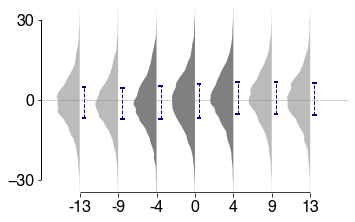

In [20]:
plt.figure()
ax = plt.gca()
utils.set_size([4,2.5])

violin_plot = ax.violinplot([
    error[digitized==v_bin] for v_bin in digit_of_interest],
    widths=1.2, showextrema=False, bw_method=.08)

for i_pc, v_pc in enumerate(violin_plot['bodies']):
    if i_pc in np.where(np.abs(neg_ref_relative)<cutoff_near)[0]: 
        v_pc.set_facecolor("#616161")    
    else: 
        v_pc.set_facecolor("#AAAAAA")
    mmm = np.mean(v_pc.get_paths()[0].vertices[:, 0])    
    v_pc.get_paths()[0].vertices[:, 0] = np.clip(v_pc.get_paths()[0].vertices[:, 0], -np.inf, mmm)
    v_pc.set_alpha(0.8)
    
ax.set_ylim([-35,35])
ax.set_xlim(0,len(neg_ref_relative)+1)
ax.set_xticks(np.arange(1,len(neg_ref_relative)+1))
ax.set_xticklabels(neg_ref_relative.astype(int))
ax.vlines(np.arange(1,len(neg_ref_relative)+1)+0.11, quantiles[:,0], quantiles[:,2], color='darkblue', linestyle='dashed', linewidth=1)
ax.hlines(quantiles[:,2], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.hlines(quantiles[:,0], np.arange(1,len(neg_ref_relative)+1)+0.05, np.arange(1,len(neg_ref_relative)+1)+0.17, color='darkblue', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)

utils.draw_publish_axis(ax, xrange=(1,7), yrange=(-30,30), xticks=None, yticks=[-30,0,30])
if utils.LABEL:
    ax.set_xlabel(r'Stimulus - Reference $(^\circ)$')
    ax.set_ylabel(r'Estimation error $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1a_fritsche.pdf',bbox_inches='tight')
plt.show()

In [21]:
id_unique = np.unique(fritsche.ID)
iqr_list  = np.nan*np.zeros([len(id_unique),len(neg_ref_relative)])

for i_id, v_id in enumerate(id_unique):
    for i_bin, v_bin in enumerate(digit_of_interest):
        idx = (fritsche.ID==v_id) & (digitized==v_bin)
        iqr_list[i_id,i_bin] = iqr(error[idx])

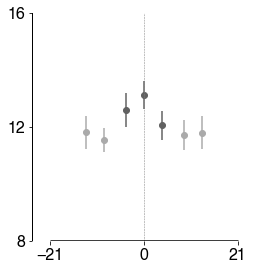

In [22]:
cutoff_in = np.abs(neg_ref_relative)<cutoff_near
m_iqr = np.mean(iqr_list,axis=0)
s_iqr = np.std(iqr_list,axis=0)/np.sqrt(len(id_unique))

plt.figure()
ax = plt.gca()
utils.set_size([3,3])
plt.vlines(neg_ref_relative[cutoff_in], 
           (m_iqr-s_iqr)[cutoff_in], (m_iqr+s_iqr)[cutoff_in], color='#616161')
plt.scatter(neg_ref_relative[cutoff_in], m_iqr[cutoff_in], color='#616161')

plt.vlines(neg_ref_relative[~cutoff_in], 
           (m_iqr-s_iqr)[~cutoff_in], (m_iqr+s_iqr)[~cutoff_in], color='#AAAAAA')
plt.scatter(neg_ref_relative[~cutoff_in], m_iqr[~cutoff_in], color='#AAAAAA')

plt.xlim([-25,25])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([8,16])

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(8,16), xticks=[-21,0,21], yticks=[8,12,16])
if utils.LABEL:
    plt.xlabel(r'Stimulus - Reference $(^\circ)$')
    plt.ylabel(r'Interquartile range $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1b_fritsche.pdf',bbox_inches='tight')
plt.show()

In [23]:
iqrr_list = np.nan*np.zeros([len(id_unique),2])
idx_n     = np.isin(digitized,[4,5,6])
idx_f     = np.isin(digitized,[2,3,7,8])

for i_id, v_id in enumerate(id_unique):
    idx = (fritsche.ID==v_id)
    iqrr_list[i_id,0] = iqr(error[idx&idx_n])
    iqrr_list[i_id,1] = iqr(error[idx&idx_f])

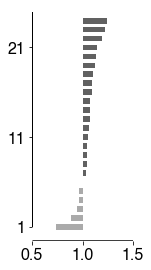

In [24]:
plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])
patches = plt.barh(np.arange(len(id_unique)), 
                   np.sort(iqrr_list[:,0]/iqrr_list[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqrr_list[:,0]/iqrr_list[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,10,20])
ax.set_yticklabels([1,11,21])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,24), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel(r'IQR ratio' '\n' '(Near / Far)')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1c_fritsche.pdf',bbox_inches='tight')
plt.show()

In [25]:
ttest  = DescrStatsW(iqrr_list[:,0]/iqrr_list[:,1]-1)
wilcox = wilcoxon(iqrr_list[:,0]/iqrr_list[:,1]-1)
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqrr_list)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(23)= 2.637444934458539 p= 0.014719344721543728
95% CI= [1.01250091 1.10343154]

Wilcoxon signed-rank test (without continuity correction)
V= 55.0 p= 0.005330443382263184


## Reference repulsion: 3. Discrimination-Estimation task (ours)

In [26]:
cde_data = cde_data[(~np.isnan(cde_data['choice'])) & (~np.isnan(cde_data['error']))]
ref_relative = [-21,-4,0,4,21] # relative orientations of reference
quantiles    = np.nan*np.empty([len(ref_relative),3])
for i_r, v_r in enumerate(ref_relative):
    idx   = cde_data.ref==-v_r
    error = cde_data.error.to_numpy()[idx]
    quantiles[i_r,0] = np.quantile(error,0.25)
    quantiles[i_r,1] = np.quantile(error,0.50)
    quantiles[i_r,2] = np.quantile(error,0.75)

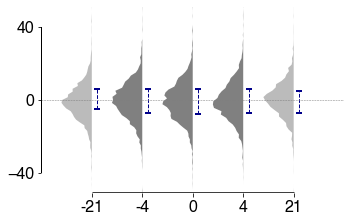

In [27]:
plt.figure()
ax = plt.gca()
utils.set_size([4,2.5])

violin_plot = ax.violinplot([cde_data.error[cde_data.ref==r] for r in ref_relative],
                            widths=1.2, showextrema=False, bw_method=.05)
for i_pc, v_pc in enumerate(violin_plot['bodies']):
    if i_pc in [1,2,3]: v_pc.set_facecolor("#616161")
    else: v_pc.set_facecolor("#AAAAAA")
    mmm = np.mean(v_pc.get_paths()[0].vertices[:, 0])    
    v_pc.get_paths()[0].vertices[:, 0] = np.clip(v_pc.get_paths()[0].vertices[:, 0], -np.inf, mmm)
    v_pc.set_alpha(0.8)

ax.set_xlim(0,len(ref_relative)+1)
ax.set_ylim([-51,51])
ax.vlines(np.arange(1,6)+0.11, quantiles[:,0], quantiles[:,2], color='darkblue', linestyle='dashed', linewidth=1)
ax.hlines(quantiles[:,2], np.arange(1,6)+0.05, np.arange(1,6)+0.17, color='darkblue', linewidth=2)
ax.hlines(quantiles[:,0], np.arange(1,6)+0.05, np.arange(1,6)+0.17, color='darkblue', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)

utils.draw_publish_axis(ax, xrange=(1,5), yrange=(-40,40), xticks=None, yticks=[-40,0,40])
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(ref_relative)
if utils.LABEL:
    ax.set_xlabel(r'Stimulus - Reference $(^\circ)$')
    ax.set_ylabel(r'Estimation error $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1a_gu.pdf',bbox_inches='tight')
plt.show()

In [28]:
iqr_list  = np.nan*np.zeros([len(np.unique(cde_data.ID)),len(ref_relative)])

for i_id, v_id in enumerate(np.unique(cde_data.ID)):
    for i_ref, v_ref in enumerate(ref_relative):
        idx = (cde_data.ID==v_id) & (-cde_data.ref==v_ref)
        iqr_list[i_id,i_ref] = iqr(cde_data.error[idx])

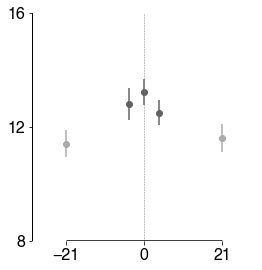

In [29]:
cutoff_in = np.abs(ref_relative)<cutoff_near
m_iqr = np.mean(iqr_list,axis=0)
s_iqr = np.std(iqr_list,axis=0)/np.sqrt(50)

plt.figure()
ax = plt.gca()
utils.set_size([3,3])
plt.vlines(np.array(ref_relative)[cutoff_in], 
           (m_iqr-s_iqr)[cutoff_in], (m_iqr+s_iqr)[cutoff_in], color='#616161')
plt.scatter(np.array(ref_relative)[cutoff_in], m_iqr[cutoff_in], color='#616161')

plt.vlines(np.array(ref_relative)[~cutoff_in], 
           (m_iqr-s_iqr)[~cutoff_in], (m_iqr+s_iqr)[~cutoff_in], color='#AAAAAA')
plt.scatter(np.array(ref_relative)[~cutoff_in], m_iqr[~cutoff_in], color='#AAAAAA')
plt.xlim([-30,30])
plt.axvline(x=0, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([8,15])

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(8,16), xticks=[-21,0,21], yticks=[8,12,16])
if utils.LABEL:
    plt.xlabel(r'Stimulus - Reference $(^\circ)$')
    plt.ylabel(r'Interquartile range $(^\circ)$')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1b_gu.pdf',bbox_inches='tight')
plt.show()

In [30]:
from scipy.stats import iqr
id_list  = np.unique(cde_data.ID)

iqrr_list = np.nan*np.empty((len(id_list),2))
for i_id, v_id in enumerate(id_list): 
    idx_n = (cde_data.ID==v_id) & (np.abs(cde_data.ref)<cutoff_near)
    idx_f = (cde_data.ID==v_id) & (np.abs(cde_data.ref)>cutoff_near)
    iqrr_list[i_id,0] = iqr(cde_data.error[idx_n])
    iqrr_list[i_id,1] = iqr(cde_data.error[idx_f])

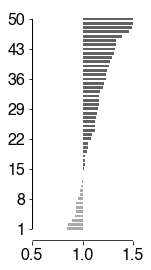

In [31]:
plt.figure()
ax = plt.gca()
utils.set_size([1.8,3])

patches = plt.barh(np.arange(len(np.unique(cde_data.ID))), 
                   np.sort(iqrr_list[:,0]/iqrr_list[:,1])-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(iqrr_list[:,0]/iqrr_list[:,1])[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.5,0.5])
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels([0.5,1.,1.5])
ax.set_yticks([0,7,14,21,28,35,42,49])
ax.set_yticklabels([1,8,15,22,29,36,43,50])

utils.draw_publish_axis(ax, xrange=(-0.5,0.5), yrange=(0,49), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel(r'IQR ratio' '\n' '(Near / Far)')
    plt.ylabel(r'Participants')
plt.savefig(f'{utils.DIR_FIGURE}/sfig1c_gu.pdf',bbox_inches='tight')
plt.show()

In [32]:
ttest  = DescrStatsW(iqrr_list[:,0]/iqrr_list[:,1]-1)
wilcox = wilcoxon(iqrr_list[:,0]/iqrr_list[:,1]-1)
print("IQR ratio vs. 1")
print('\nPaired samples t-test')
print(f't({len(iqrr_list)-1})=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', np.array(ttest.tconfint_mean())+1)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

IQR ratio vs. 1

Paired samples t-test
t(49)= 5.4325245904675175 p= 1.7288022985514728e-06
95% CI= [1.08671275 1.18852892]

Wilcoxon signed-rank test (without continuity correction)
V= 177.0 p= 8.775508182574744e-06
